In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict

# Evaluation on controlled dataset

In [2]:
annot_fever_dplaceq = "/export/usuarios_ml4ds/lbartolome/Repos/umd/mind/data/ablations/discrepancies/results/v1/FEVER-DPLACE-Q_v2_discp.csv"

In [3]:
df = pd.read_csv(annot_fever_dplaceq)
#df = df[df.label!="NOT_ENOUGH_INFO"]

models = ["qwen:32b", "llama3.3:70b", "gpt-4o-2024-08-06"]
f1_results = []

for model in models:
    per_class_f1 = []
    
    for label in df["label"].unique():
        # Create binary labels (1 if this label, 0 otherwise)
        true_binary = (df["label"] == label).astype(int)
        pred_binary = (df[f"discp_{model}"] == label).astype(int)

        # Compute F1-score for this specific label
        f1 = f1_score(true_binary, pred_binary, average="binary")
        per_class_f1.append(f1)

        # Store per-class F1-score
        f1_results.append({"Label": label, "Model": model, "F1-score": f1})

    # Compute Weighted-F1 for the model
    weighted_f1 = f1_score(df["label"], df[f"discp_{model}"], average="weighted")
    f1_results.append({"Label": "Weighted-F1", "Model": model, "F1-score": weighted_f1})

# Convert results to DataFrame
f1_df = pd.DataFrame(f1_results)

# Sort models correctly
model_order = models
f1_df["Model"] = pd.Categorical(f1_df["Model"], categories=model_order, ordered=True)

# Pivot for LaTeX output
latex_table = f1_df.pivot(index="Label", columns="Model", values="F1-score")
latex_table = latex_table[model_order]  # Ensure correct column order

# Convert to LaTeX table
latex_output = latex_table.to_latex(float_format="%.3f", caption="F1-score per Label and Weighted-F1", label="tab:f1_scores")
print(latex_output)

latex_table

\begin{table}
\caption{F1-score per Label and Weighted-F1}
\label{tab:f1_scores}
\begin{tabular}{lrrr}
\toprule
Model & qwen:32b & llama3.3:70b & gpt-4o-2024-08-06 \\
Label &  &  &  \\
\midrule
CONTRADICTION & 0.925 & 0.845 & 0.852 \\
CULTURAL_DISCREPANCY & 0.882 & 0.804 & 0.848 \\
NOT_ENOUGH_INFO & 0.839 & 0.679 & 0.704 \\
NO_DISCREPANCY & 0.970 & 0.923 & 0.881 \\
Weighted-F1 & 0.909 & 0.824 & 0.831 \\
\bottomrule
\end{tabular}
\end{table}



Model,qwen:32b,llama3.3:70b,gpt-4o-2024-08-06
Label,,,
CONTRADICTION,0.924528,0.844828,0.852174
CULTURAL_DISCREPANCY,0.882353,0.804124,0.847826
NOT_ENOUGH_INFO,0.838710,0.679245,0.703704
NO_DISCREPANCY,0.969697,0.923077,0.880734
Weighted-F1,0.909101,0.823649,0.830629


/tmp/ipykernel_63669/2462201246.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


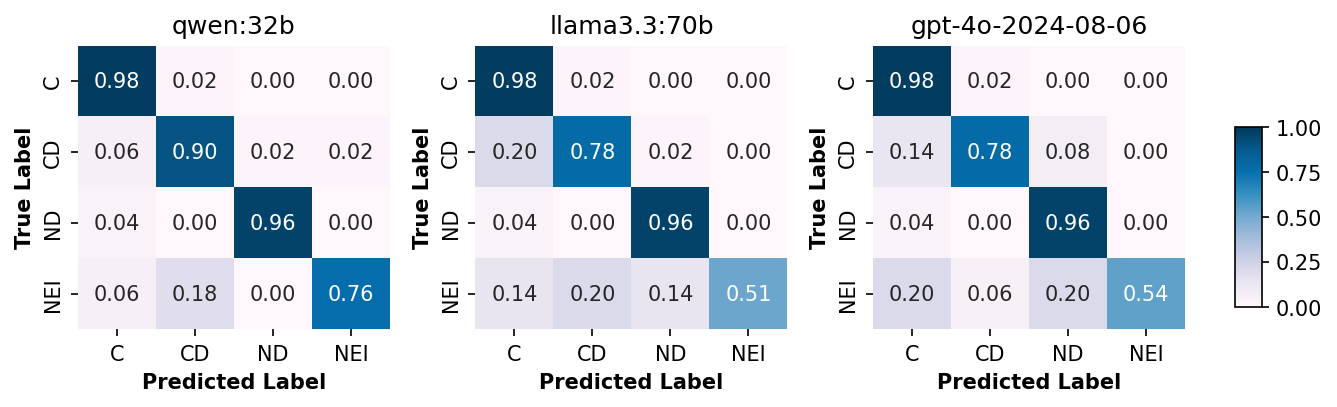

In [4]:
true_col = "label"
pred_cols = OrderedDict([
    ("qwen:32b", "discp_qwen:32b"),
    ("llama3.3:70b", "discp_llama3.3:70b"),
    ("gpt-4o-2024-08-06", "discp_gpt-4o-2024-08-06"),
])

# fixed order and pretty tick labels
order = ["CONTRADICTION", "CULTURAL_DISCREPANCY", "NO_DISCREPANCY", "NOT_ENOUGH_INFO"]
abbr = {"CONTRADICTION": "C", "CULTURAL_DISCREPANCY": "CD", "NO_DISCREPANCY": "ND", "NOT_ENOUGH_INFO": "NEI"}
true_labels = [abbr[x] for x in order]
pred_labels = true_labels  # same order for columns

def row_norm_confusion(y_true, y_pred, labels):
    ct = pd.crosstab(
        pd.Categorical(y_true, categories=labels),
        pd.Categorical(y_pred, categories=labels),
        dropna=False
    ).astype(float)
    row_sums = ct.sum(axis=1).replace(0, np.nan)
    m = (ct.T / row_sums).T.fillna(0.0)
    # return as DataFrame with pretty tick labels to pass to seaborn
    m.index = [abbr[i] for i in m.index]
    m.columns = [abbr[j] for j in m.columns]
    return m

# compute matrices for each model
models = OrderedDict()
for title, col in pred_cols.items():
    models[title] = row_norm_confusion(df[true_col], df[col], order)

# --- Plotting (your styling) ---
fig, axes = plt.subplots(1, 3, figsize=(9, 3), dpi=150)
vmin, vmax = 0.0, 1.0
cmap = "PuBu"  # Updated color palette

for ax, (title, matrix) in zip(axes, models.items()):
    sns.heatmap(
        matrix, annot=True, fmt=".2f", cmap=cmap, vmin=vmin, vmax=vmax,
        xticklabels=pred_labels, yticklabels=true_labels, ax=ax, cbar=False
    )
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Predicted Label", fontsize=10, fontweight='bold')
    ax.set_ylabel("True Label", fontsize=10, fontweight='bold')

# shared colorbar
cbar_ax = fig.add_axes([0.92, 0.3, 0.02, 0.4])
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(bottom=0.25)

# optional: save
plt.savefig("/export/usuarios_ml4ds/lbartolome/Repos/umd/mind/figures/thesis/confusion_fever_d_place_q_fixed.png", dpi=300, bbox_inches="tight")

plt.show()


# Final run

In [5]:
paths_final = [
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc15_complete/answers/questions_topic_15_qwen:32b_23400_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc11_complete/answers/questions_topic_11_qwen:32b_14300_results_model30tpc_thr__dynamic.parquet",
    "/export/usuarios_ml4ds/lbartolome/Repos/umd/LinQAForge/_old_dont_remove/data_arr_feb/GENERATIONS/outs_good_model_tpc24_complete/answers/questions_topic_24_qwen:32b_18900_results_model30tpc_thr__dynamic.parquet",
]

all_ = []
for path in paths_final:
    df = pd.read_parquet(path)
    tpc= path.split("_tpc")[-1].split("_")[0]
    df["topic"]=tpc

    # cleaning 
    df.loc[df['answer_t'].str.contains("cannot answer the question given the context", na=False), 'discrepancy'] = "NOT_ENOUGH_INFO"
    df.loc[df["answer_t"] == "I cannot answer given the context.", ["discrepancy"]] = "NOT_ENOUGH_INFO"
    df.loc[df["discrepancy"] == "TYPE: NO_", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "NO_ONGOING_DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: CULTURAL_ DISCREPANCY", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if we consider that slight variations in recommendations might exist due to cultural influences or different parenting practices, though it's a weak case for this category)", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "CULTURAL_DISCREPANCY (if you consider the slight difference in number of exposures as stemming from different studies or expert opinions)", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "TYPE: CULTURAL_", ["discrepancy"]] = "CULTURAL_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO_ DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df.loc[df["discrepancy"] == "DISCREPANCY_ TYPE: NO DISCREPANCY", ["discrepancy"]] = "NO_DISCREPANCY"
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ DISCREPANCY", "NO_DISCREPANCY")
    df["discrepancy"] = df["discrepancy"].str.replace("NO_ENOUGH_INFO", "NOT_ENOUGH_INFO")
    df["discrepancy"] = df["discrepancy"].str.replace("CULTURAL_ DISCREPANCY", "CULTURAL_DISCREPANCY")
    
    all_.append(df)

df = pd.concat(all_)
valid_values = {"CONTRADICTION", "NO_DISCREPANCY", "CULTURAL_DISCREPANCY", "NOT_ENOUGH_INFO"}
df = df[df["discrepancy"].isin(valid_values)]
print(df.discrepancy.unique())
len(df)

['NOT_ENOUGH_INFO' 'NO_DISCREPANCY' 'CULTURAL_DISCREPANCY' 'CONTRADICTION']


258044

In [6]:
print(df.columns)

# remove duplicates by question and passage_t (i.e., relevant passage is the same for the same question)
df = df.drop_duplicates(subset=["question", "passage_t"])
len(df)

Index(['question_id', 'doc_id', 'question', 'passage_s', 'answer_s',
       'passage_t', 'answer_t', 'discrepancy', 'reason', 'topic'],
      dtype='object')


129022

In [7]:
discrepancy_counts = df.groupby("topic")["discrepancy"].value_counts().unstack().fillna(0)
discrepancy_counts

discrepancy,CONTRADICTION,CULTURAL_DISCREPANCY,NOT_ENOUGH_INFO,NO_DISCREPANCY
topic,,,,
11,75,66,41426,2997
15,72,127,42094,2342
24,40,206,37070,2507
